## Referências
https://github.com/elena-sharova/IsolationForest/blob/master/IsolationForest_v0.1.ipynb
https://www.youtube.com/watch?v=5p8B2Ikcw-k
https://analyzecore.com/2018/06/13/anomaly-detection-for-business-metrics-with-r/

##Setup

In [0]:
!apt-get update

!pip install -U -q PyDrive
!pip install matplotlib
!pip install numpy
!pip install pandas --upgrade
!pip install sklearn

In [0]:

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime
import gc

##Funções Auxiliares

In [0]:
def byte_decoder(val):
    # decodes byte literals to strings
    
    return val.decode('utf-8')

In [0]:
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [0]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    # print GridSearch cross-validation for parameters
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

## Tratamento Base

###Base SF (4 variáveis)

In [0]:
gc.collect()
target = 'target'
sf = datasets.fetch_kddcup99(subset='SF', percent10=True)
dfSF=pd.DataFrame(sf.data, 
                  columns=["duration", "service", "src_bytes", "dst_bytes"])
assert len(dfSF)>0, "SF dataset no loaded."

dfSF[target]=sf.target
anomaly_rateSF = 1.0 - len(dfSF.loc[dfSF[target]==b'normal.'])/len(dfSF)

"SF Anomaly Rate is:"+"{:.1%}".format(anomaly_rateSF)

### Base SA (41 variáveis)

In [0]:
sa = datasets.fetch_kddcup99(subset='SA', percent10=True)
dfSA=pd.DataFrame(sa.data, 
                  columns=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
                           "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
                           "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
                           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
                           "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
                           "dst_host_rerror_rate","dst_host_srv_rerror_rate"])
assert len(dfSA)>0, "SA dataset not loaded."

dfSA[target]=sa.target
anomaly_rateSA = 1.0 - len(dfSA.loc[dfSA[target]==b'normal.'])/len(dfSA)

"SA Anomaly Rate is:"+"{:.1%}".format(anomaly_rateSA)

## Processamento dos dados

In [0]:
toDecodeSA = ['protocol_type', 'service', 'flag', target]
toDecodeSF = ['service', target]

print ("Original SA Target values:",set(dfSA[target]))

['service', 'target']

In [0]:
# apply hot encoding to fields of type string
# convert all abnormal target types to single anomaly class

dfSF['binary_target'] = [1 if x==b'normal.' else -1 for x in dfSF[target]]
dfSA['binary_target'] = [1 if x==b'normal.' else -1 for x in dfSA[target]]

leSA = preprocessing.LabelEncoder()

for f in toDecodeSA:
    dfSA[f] = list(map(byte_decoder, dfSA[f]))
    dfSA[f] = leSA.fit_transform(dfSA[f])

leSF = preprocessing.LabelEncoder()

for f in toDecodeSF:
    dfSF[f] = list(map(byte_decoder, dfSF[f]))
    dfSF[f] = leSF.fit_transform(dfSF[f])
    
    
#dfSA_normed = preprocessing.normalize(dfSA.drop([target,'binary_target'], axis=1))
#dfSF_normed = preprocessing.normalize(dfSF.drop([target, 'binary_target'], axis=1))

array([[-0.17641854,  0.61294077,  0.39833867,  0.65917101],
       [-0.19631525,  0.68206905,  0.46695146,  0.52744522],
       [-0.18742607,  0.65118487,  0.44443456,  0.58592462],
       ...,
       [-0.18939444,  0.65802367,  0.43706742,  0.58318665],
       [-0.18691023,  0.64939265,  0.4605547 ,  0.57553724],
       [-0.18862485,  0.65534986,  0.44150333,  0.58310551]])

## Treinamento Base SA

### Treinamento

In [0]:
X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(dfSA.drop([target, 'binary_target'], axis=1), 
                                                                dfSA['binary_target'], 
                                                    test_size=0.33, random_state=11)

#X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(dfSA_normed, dfSA['binary_target'], 
#                                                    test_size=0.33, random_state=11)

In [0]:
clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination=0.15, n_estimators=100, n_jobs=-1)

In [0]:
start = datetime.datetime.now()
clfIF.fit(X_train_sa,y_train_sa)
y_pred_train = clfIF.predict(X_train_sa)
end = datetime.datetime.now()
print (end-start)

0:00:11.755082


### Resultados

             precision    recall  f1-score   support

    anomaly       0.23      1.00      0.37      2327
     normal       1.00      0.88      0.94     65111

avg / total       0.97      0.88      0.92     67438

AUC:  93.8%


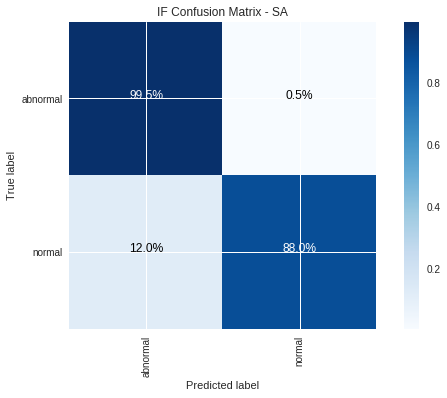

In [0]:
print(classification_report(y_train_sa, y_pred_train, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sa, y_pred_train)))
cm = confusion_matrix(y_train_sa, y_pred_train)
plot_confusion_matrix(cm, title="IF Confusion Matrix - SA", save=True, saveas="IF_SA.png")

## Treinamento Base SF

### Treinamento

In [0]:
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfSF.drop([target, 'binary_target'], axis=1), 
                                                                dfSF['binary_target'], test_size=0.33, random_state=11)


clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_estimators=100, n_jobs=-1)


start = datetime.datetime.now()
clfIF.fit(X_train_sf,y_train_sf)
y_pred_train = clfIF.predict(X_train_sf)
end = datetime.datetime.now()
print (end-start)

0:00:05.165922


### Resultados

             precision    recall  f1-score   support

    anomaly       0.11      0.37      0.17      2225
     normal       0.97      0.86      0.91     46843

avg / total       0.93      0.84      0.88     49068

AUC:  61.4%


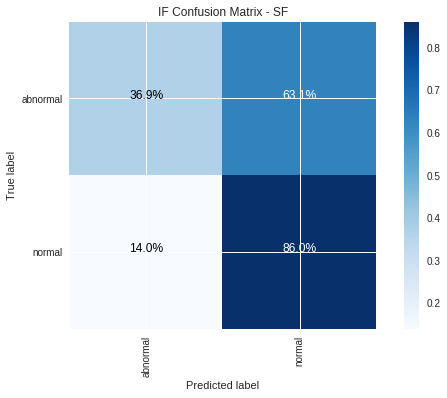

In [0]:
print(classification_report(y_train_sf, y_pred_train, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train)))
cm = confusion_matrix(y_train_sf, y_pred_train)
plot_confusion_matrix(cm, title="IF Confusion Matrix - SF", save=True, saveas="IF_SF.png")

## Teste Base SA

             precision    recall  f1-score   support

    anomaly       0.21      0.99      0.35      1050
     normal       1.00      0.88      0.94     32167

avg / total       0.97      0.88      0.92     33217

AUC:  93.6%


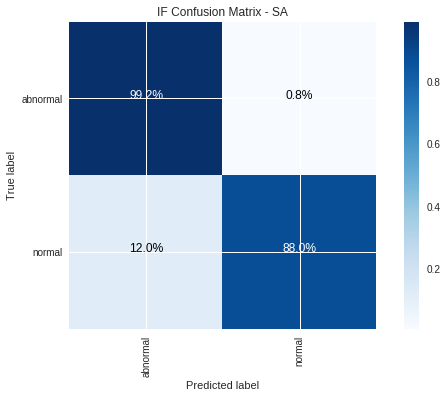

In [0]:
clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_estimators=100, n_jobs=-1)

clfIF.fit(X_train_sa,y_train_sa)
y_pred_test = clfIF.predict(X_test_sa)

print(classification_report(y_test_sa, y_pred_test, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sa, y_pred_test)))
cm = confusion_matrix(y_test_sa, y_pred_test)
plot_confusion_matrix(cm, title="IF Confusion Matrix - SA", save=True, saveas="IF_SA_Test.png")

###Teste Base SF

             precision    recall  f1-score   support

    anomaly       0.11      0.36      0.17      1073
     normal       0.97      0.86      0.91     23096

avg / total       0.93      0.84      0.88     24169

AUC:  61.1%


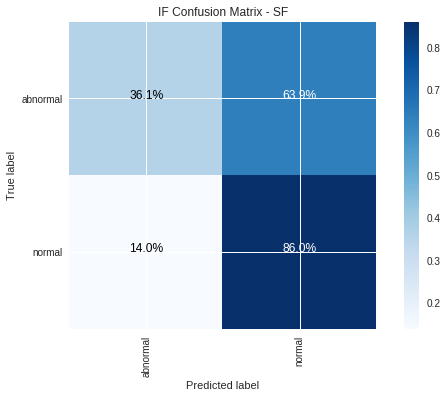

In [0]:
clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_estimators=100, n_jobs=-1)

clfIF.fit(X_train_sf,y_train_sf)
y_pred_test = clfIF.predict(X_test_sf)

print(classification_report(y_test_sf, y_pred_test, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test)))
cm = confusion_matrix(y_test_sf, y_pred_test)
plot_confusion_matrix(cm, title="IF Confusion Matrix - SF", save=True, saveas="IF_SF_Test.png")

##Parameters de Isolation Forest - n_estimators

In [0]:
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

{'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

In [0]:
gs = GridSearchCV(IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_jobs=-1),
                  param_grid={'n_estimators': range(20, 230, 30)},
                  scoring=scoring, refit='Recall')
gs.fit(X_train_sa, y_train_sa)
results = gs.cv_results_

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please

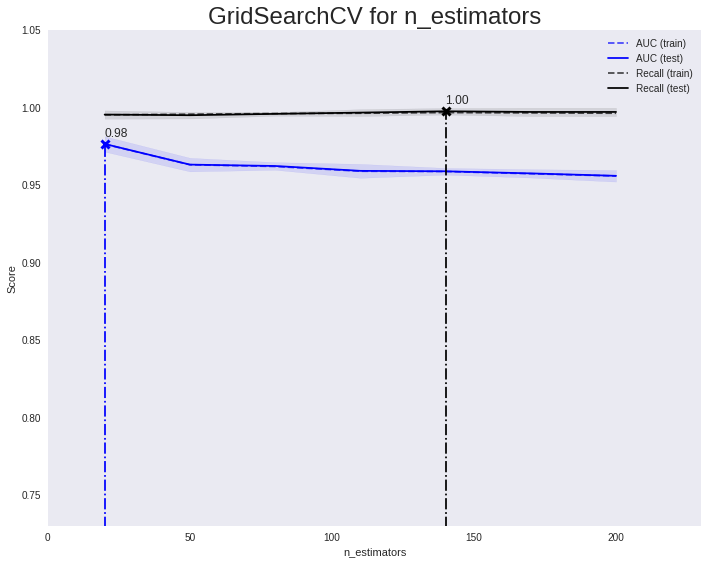

In [0]:
plot_gridsearch_cv(results, "n_estimators", 0, 230, 0.73, 1.05, save=True, saveas="GS_n_est.png")

##Setting Parameters of Isolation Forest - max_samples

**max_samples** controls the number of records to draw (with replacement, by default) from the training set to build each tree

In [0]:
gs_ms = GridSearchCV(IsolationForest(random_state=11, contamination = 0.15, n_estimators=150, n_jobs=-1),
                  param_grid={'max_samples': np.arange(0.1, 1.0, 0.1)},
                  scoring=scoring, refit='Recall')
gs_ms.fit(X_train_sa, y_train_sa)
results = gs_ms.cv_results_

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please

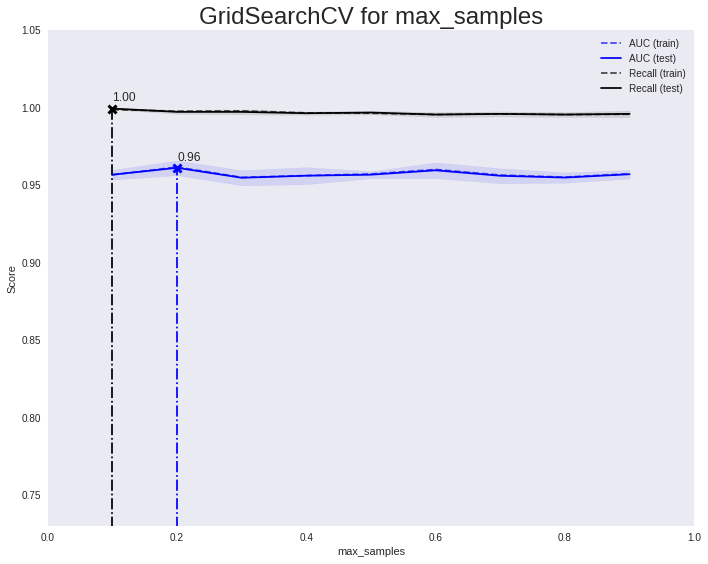

In [0]:
plot_gridsearch_cv(results, "max_samples", 0, 1, 0.73, 1.05, save=True, saveas="GS_max_samples.png")

## Setting Parameters of Isolation Forest - contamination

**Contamination** controls the threshold of the anomaly score beyond which instances are classified as outliers.

In [0]:
gs_cont = GridSearchCV(IsolationForest(random_state=11, max_samples=0.10, n_estimators=150, n_jobs=-1),
                  param_grid={'contamination': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='Recall')
gs_cont.fit(X_train_sa, y_train_sa)
results = gs_cont.cv_results_

In [0]:
plot_gridsearch_cv(results, "contamination", 0, 0.20, 0.80, 1.08, save=True, saveas="GS_cont.png")